# Further cleaning

In [1043]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import style
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
plt.style.use('seaborn-poster') 


In [1044]:
perfumes_data = pd.read_csv(r'E:\parsing project\perfumes_data_almost_clean.csv')
reviews_data = pd.read_csv(r'E:\parsing project\reviews_clean.csv')

In [1045]:
for i in perfumes_data.columns:
    perfumes_data[i] = perfumes_data[i].str.lower()

In [1046]:
perfumes_data.loc[3181, 'nm'] = 'eau de parfum spray 3.3 oz'

In [1047]:
def ismissing(df):
    for i in df.columns:
        print(f'Missing data for column {i}: {round((100*df[i].isna().sum()/len(df)), 3)}%')

In [1048]:
ismissing(perfumes_data)

Missing data for column index: 0.125%
Missing data for column Price: 15.535%
Missing data for column nm: 15.535%
Missing data for column Design House: 2.615%
Missing data for column Fragrance Notes: 9.215%
Missing data for column Year: 13.325%


In [1049]:
ismissing(reviews_data)

Missing data for column author_date: 0.0%
Missing data for column review_text: 0.0%
Missing data for column product: 0.0%
Missing data for column rating out of 5: 6.493%
Missing data for column date: 0.0%
Missing data for column authors: 0.0%


Keep in mind that the answers are exclusive to the parsed site, i.e. if we parse another site, the answers may differ. Suppose that we are trying to build a recommender for **that particular site.**

In [1050]:
#drop non-perfume items and bundled items
trei = perfumes_data.dropna(subset = 'nm')
not_perfume_ids = trei[~trei['nm'].str.contains('perfume|parfum|toilette spray|cologne')].index
bundles = trei[trei['nm'].str.contains('&')].index
perfumes_data = perfumes_data.drop(np.concatenate([not_perfume_ids, bundles]))
perfumes_data = perfumes_data.drop_duplicates(subset =['index', 'Fragrance Notes'])
perfumes_data_without_missing_price = perfumes_data[~perfumes_data['nm'].isna()]
perfume_names = set(perfumes_data_without_missing_price['index'])
reviews_data = reviews_data[reviews_data['product'].isin(perfume_names)]

#merge dataframes
merged = reviews_data.merge(perfumes_data_without_missing_price, how = 'left', left_on = 'product', right_on = 'index')
merged = merged.drop_duplicates(subset = ['authors', 'review_text'])



#find all authors by using regex
merged['authors'] = merged['authors'].str.strip()
p = re.compile("written by (.*) on")
merged['authors'] = merged['author_date'].str.findall(p)
merged['authors'] = merged['authors'].str[0]
merged = merged.drop('index', axis = 1)

#make anonymous users unique
anon_ids = merged[merged['authors'] == 'anonymous'].index
merged.loc[anon_ids, 'authors'] = merged.loc[anon_ids]['authors'] + '_' + merged.loc[anon_ids].reset_index()['index'].values.astype(str)


#overall unique items - 2199
#overall unique reviews - 39300
#overall unique users - 24523
#overall # of observations - 39368

In [1051]:

#3 authors had nan values as names
unique_id_1q3w = [2558, 17138,36115,37734,38264]
unique_id_1q4w = [15118,15914,15915,20888,22555,35337]
unique_id_1q5w = [13149,19570,25466]
merged.loc[unique_id_1q3w, 'authors'] = 'unique_id_1q3w'
merged.loc[unique_id_1q4w, 'authors'] = 'unique_id_1q4w'
merged.loc[unique_id_1q5w, 'authors'] = 'unique_id_1q5w'

Assign unique ids from 0 to length of authors/items:

In [1052]:
author_ids_dict = {}
author_ids = 0
authors = set(merged['authors'])

for i in authors:
    author_ids_dict[i] = author_ids
    author_ids += 1

item_ids_dict = {}
item_ids = 0
items = set(merged['product'])

for i in items:
    item_ids_dict[i] = item_ids
    item_ids += 1

In [1054]:
merged['author_id'] = merged['authors'].map(author_ids_dict)
merged['item_id'] = merged['product'].map(item_ids_dict)

To find the most cheap and expensive perfumes, we need to calculate price per 1 oz to be able to compare them. It would also be ideal to do some inflation indexing (since one dollar today is not the same as one dollar tomorrow), but for the sake of simplicity, let's assume that there is no inflation and we don't need to index anything.

Some perfumes do not have their prices on the website. While it may be tempting to fill them up by looking at other sites and sources, after some research, I found that this may not be a good idea, since perfume prices can differ drastically (because of promos/sponsorships). Unfortunately, we have to leave them be and exclude them.

In [1055]:
merged['oz'] = merged['nm'].str.extract(r"(\d+\.\d+)")

In [1056]:
intoz = merged[merged['oz'].isna()].index
merged.loc[intoz, 'oz'] = merged.loc[intoz, 'nm'].str.extract("(\d+)")[0]

In [1057]:
# set all vials as 0.05 oz

vial_ids = merged[merged['oz'].isna()].index
merged.loc[vial_ids, 'oz'] = 0.05

In [1058]:
ismissing(merged)

Missing data for column author_date: 0.0%
Missing data for column review_text: 0.0%
Missing data for column product: 0.0%
Missing data for column rating out of 5: 6.355%
Missing data for column date: 0.0%
Missing data for column authors: 0.0%
Missing data for column Price: 0.0%
Missing data for column nm: 0.0%
Missing data for column Design House: 2.337%
Missing data for column Fragrance Notes: 2.992%
Missing data for column Year: 4.072%
Missing data for column author_id: 0.0%
Missing data for column item_id: 0.0%
Missing data for column oz: 0.0%


Notice that we have some missing information on Rating, Design House, Fragnance notes and Year. While the first one is very important and should be dealt with, three others won't really matter for our recommender system.

In [1059]:
merged['Price'] = merged['Price'].str.extract(r"(\d+\.\d+)").astype(float)

In [1060]:
merged['Price per oz ($)'] = round(merged['Price']/merged['oz'].astype(float), 2)

We will try to restore missing ratings with the help of NLP later.

In [1061]:
merged['for_nlp'] = np.where(merged['rating out of 5'].isna(), 1, 0)

In [1062]:
merged.head()

,author_date,review_text,product,rating out of 5,date,authors,Price,nm,Design House,Fragrance Notes,Year,author_id,item_id,oz,Price per oz ($),for_nlp
0,"20300_written by jan on december 06, 2022",one of my favorites!!! i don't care when i wea...,kate spade live colorfully,5 stars,2022-12-06,jan,19.99,eau de parfum spray 0.27 oz travel spray,kate spade,"mandarin orange, water lilly, star anise, tiar...",2013,12639,1305,0.27,74.04,0
1,"20301_written by ashley allure on june 17, 2022",i love it! i pondered on it for awhile. it’s e...,kate spade live colorfully,5 stars,2022-06-17,ashley allure,19.99,eau de parfum spray 0.27 oz travel spray,kate spade,"mandarin orange, water lilly, star anise, tiar...",2013,21377,1305,0.27,74.04,0
2,"20302_written by love it on february 19, 2022",love this and the travel spray bottle is so co...,kate spade live colorfully,5 stars,2022-02-19,love it,19.99,eau de parfum spray 0.27 oz travel spray,kate spade,"mandarin orange, water lilly, star anise, tiar...",2013,13232,1305,0.27,74.04,0
3,"20303_written by cheryl on september 12, 2021",i love the fragrance which is light and not ov...,kate spade live colorfully,5 stars,2021-09-12,cheryl,19.99,eau de parfum spray 0.27 oz travel spray,kate spade,"mandarin orange, water lilly, star anise, tiar...",2013,23699,1305,0.27,74.04,0
4,"20304_written by deirdre w. on july 16, 2021",pretty fragrance i get a lot of compliments on...,kate spade live colorfully,5 stars,2021-07-16,deirdre w.,19.99,eau de parfum spray 0.27 oz travel spray,kate spade,"mandarin orange, water lilly, star anise, tiar...",2013,13898,1305,0.27,74.04,0


# EDA

Top 5 most cheap and expensive perfumes on this website (calculate price per 1 oz):

In [1063]:
most_expensive = pd.DataFrame(merged.groupby('product')[['Price per oz ($)', 'review_text']].agg({'Price per oz ($)':'max', 'review_text':'count'}).sort_values(by = 'Price per oz ($)',ascending = False).nlargest(5, columns = 'Price per oz ($)'))
most_expensive

,Price per oz ($),review_text
product,,
clive christian no 1,457.55,3
clive christian vanilla orchid,331.24,1
creed aventus for her,309.99,35
tom ford rose prick,304.99,1
tom ford fucking fabulous,297.05,8


In [1064]:
most_cheap = pd.DataFrame(merged.groupby('product')[['Price per oz ($)', 'review_text']].agg({'Price per oz ($)':'max', 'review_text':'count'}).sort_values(by = 'Price per oz ($)',ascending = False).nsmallest(5, columns = 'Price per oz ($)'))
most_cheap

,Price per oz ($),review_text
product,,
hustler muse,2.06,1
armaf gem amethyst,2.06,1
glee diva glam,2.35,1
beverly hills 90210 very sexy 2,2.64,1
hustler diva,2.94,1


The PPO (price per oz) of the most expensive perfume seems to be around 460$, while PPO of the cheapest perfumes is only around ~2$. 

Let's find the most cheap and expensive items with at least 30 reviews:

In [1065]:
price_review = pd.DataFrame(merged.groupby('product')[['Price per oz ($)', 'review_text']].agg({'Price per oz ($)':'max', 'review_text':'count'}).sort_values(by = 'Price per oz ($)',ascending = False))
price_review[price_review['review_text'] >29].nlargest(5, 'Price per oz ($)')

,Price per oz ($),review_text
product,,
creed aventus for her,309.99,35
creed royal oud,217.27,46
baccarat rouge 540,204.16,30
tiffany & co spray,194.06,34
la vie est belle,189.54,380


In [1066]:
price_review[price_review['review_text'] > 29].nsmallest(5, 'Price per oz ($)')

,Price per oz ($),review_text
product,,
charlie red,3.23,37
charlie blue,3.53,40
charlie white,4.41,32
tea rose,4.75,86
white shoulders,5.55,155


In both cases, there is a sudden transition in the number of reviews as the price increases/decreases.

Most popular perfumes by user reviews:

In [1103]:
merged.groupby('product')[['Price per oz ($)', 'review_text']].agg({'Price per oz ($)':'max', 'review_text':'count'}).sort_values(by = 'review_text',ascending = False).nlargest(5, columns = 'review_text')

,Price per oz ($),review_text
product,,
d & g light blue,61.24,735
simply belle,14.70,461
obsession perfume,12.64,405
calvin klein euphoria,38.99,398
angel,65.29,383


It seems like the users of this site give preference to low-mid price range - the most reviewed perfumes have an average of ~38 dollars per oz.

Most rated items:

In [1068]:
merged.groupby(['product'])[['Price per oz ($)', 'rating out of 5']].agg({'Price per oz ($)':'max', 'rating out of 5':'count'}).sort_values(by = 'rating out of 5',ascending = False).nlargest(5, 'rating out of 5' )

,Price per oz ($),rating out of 5
product,,
d & g light blue,61.24,673
simply belle,14.70,425
obsession perfume,12.64,376
calvin klein euphoria,38.99,358
la vie est belle,189.54,355


Interestingly, the last position of the most rated items does not coincide with the last position of most popular perfumes by user reviews. This finding  basically shows, that some reviews do not have rating, as was seen earlier.

Rating spread:

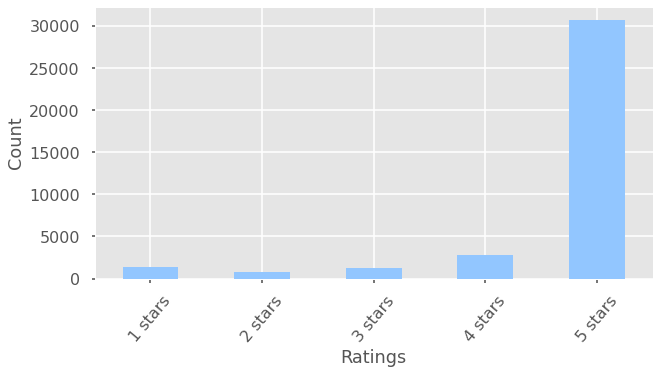

In [1069]:
plt.figure(figsize = (10, 5))
merged['rating out of 5'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.xticks(rotation=50)
plt.show()

This is an important finding. Most of the perfume reviews are skewed towards 5 stars. It might be the case that people are more likely to rate perfumes that they think they will like and less likely to rate the items they think they dislike (Marlin et.al., 2011). Unfortunately, it is not possible to prove this hypothesis without conducting an experiment targeted towards the users of this website.

Let's compute the average rating for the most reviewed products:

In [1070]:
merged['num_rating'] = merged[merged['rating out of 5'].notnull()]['rating out of 5'].apply(lambda x: x.split()[0]).astype(int)

In [1071]:
merged.groupby('product')[['review_text','num_rating']].agg({'review_text':'count','num_rating':'mean'}).nlargest(5, 'review_text')

,review_text,num_rating
product,,
d & g light blue,735,4.748886
simply belle,461,4.616471
obsession perfume,405,4.736702
calvin klein euphoria,398,4.835196
angel,383,4.679887


Most active users:

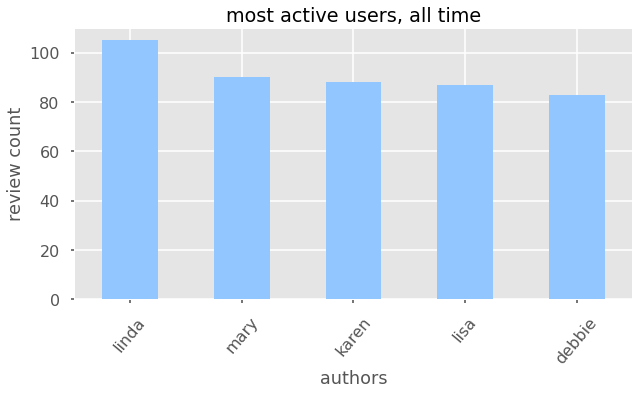

In [1072]:
plt.figure(figsize = (10,5))
merged.groupby(['authors']).agg('count')['review_text'].sort_values(ascending = False).nlargest(5).plot(kind = 'bar')
plt.ylabel('review count')
plt.title('most active users, all time')
plt.xticks(rotation=50)
plt.show()


All of the most active users have more than 80 reviews.

Top 10 days with the most user activity:

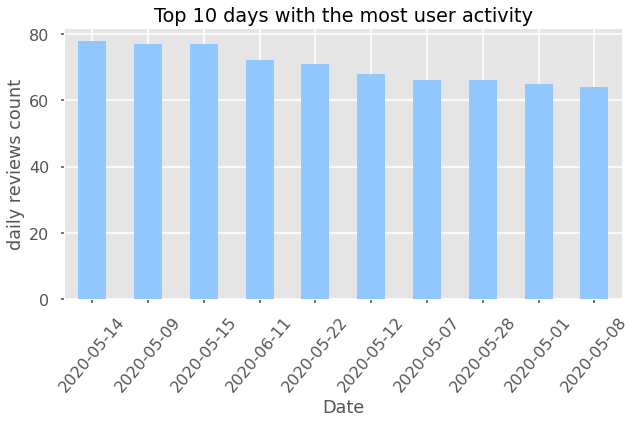

In [1073]:
plt.figure(figsize = (10, 5))
merged['date'].value_counts().nlargest(10).plot(kind = 'bar')
plt.ylabel('daily reviews count')
plt.xlabel('Date')
plt.title('Top 10 days with the most user activity')
plt.xticks(rotation=50)
plt.show()


All of them are in 2020 (May, June), which is logical, since people were under a lockdown due to COVID-19.

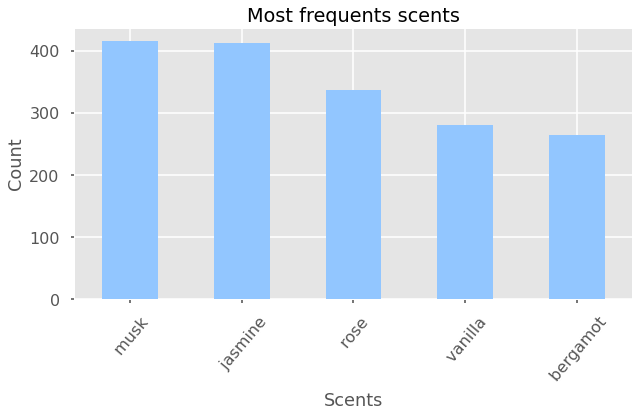

In [1074]:
plt.figure(figsize = (10, 5))
scents = merged[(merged['Fragrance Notes'].notnull()) & (merged['Year'].notnull())][['product', 'Fragrance Notes']].drop_duplicates()['Fragrance Notes'].str.split(',').explode().value_counts().nlargest(5)
scents.plot(kind = 'bar')
plt.xlabel('Scents')
plt.ylabel('Count')
plt.title('Most frequents scents')
plt.xticks(rotation=50)
plt.show()

Most frequent design houses:

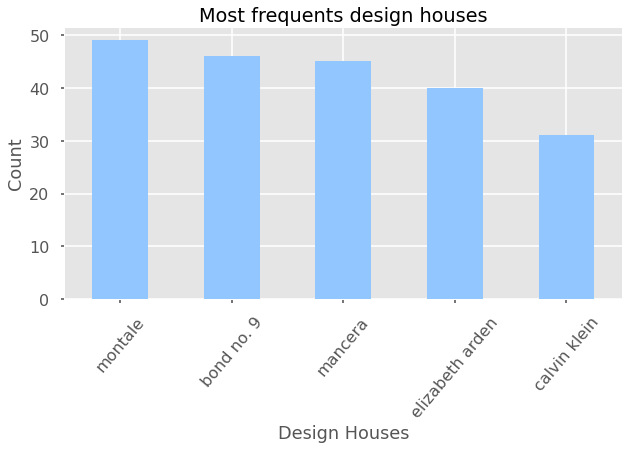

In [1075]:
plt.figure(figsize = (10, 5))
houses = merged[['product', 'Design House']].drop_duplicates()['Design House'].value_counts().nlargest(5)
houses.plot(kind = 'bar')
plt.xlabel('Design Houses')
plt.ylabel('Count')
plt.title('Most frequents design houses')
plt.xticks(rotation=50)
plt.show()

Most frequent release years:

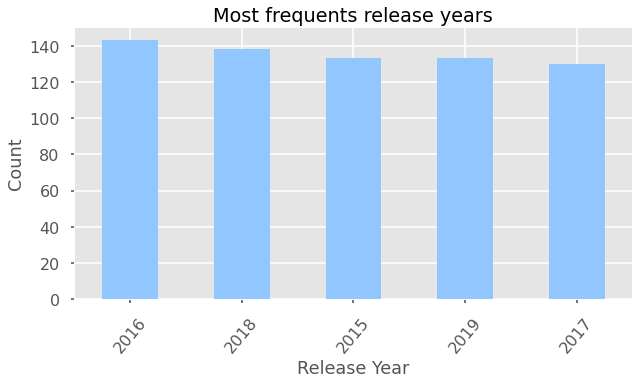

In [1076]:
plt.figure(figsize = (10, 5))
houses = merged[['product','Year']].drop_duplicates()['Year'].value_counts().nlargest(5)
houses.plot(kind = 'bar')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.title('Most frequents release years')
plt.xticks(rotation=50)
plt.show()

Wordcloud for all reviews:

In [1077]:
stopwords = set(STOPWORDS)
stopwords.update(['perfume', 'smell', 'scent', 'fragrance', 'one', 'wear', 'wearing'])

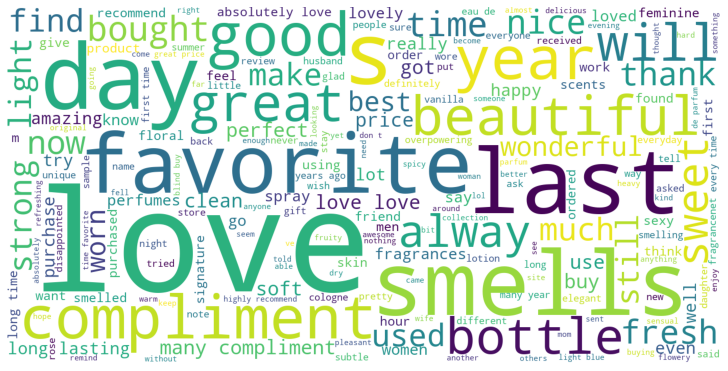

In [1078]:
text = " ".join(review for review in merged.review_text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1400, height=700).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Since the reviews are skewed towards positive as was seen before, most of the words are positive. Let's splice them by ratings:

Wordcloud for 3 star reviews or less:

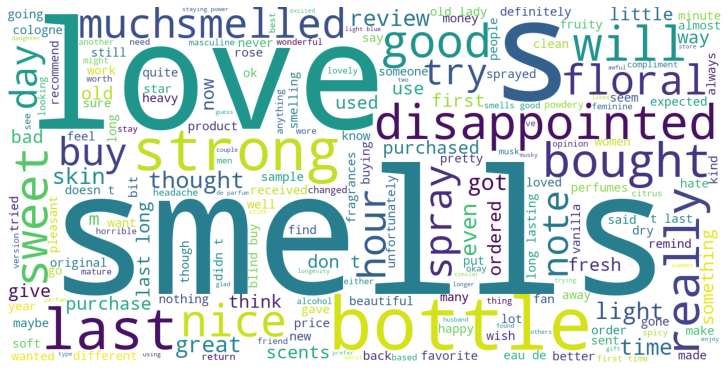

In [1079]:
text_low = " ".join(review for review in merged[merged['num_rating'] <=3].review_text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1400, height=700).generate(text_low)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Wordcloud for 4-5 star reviews:

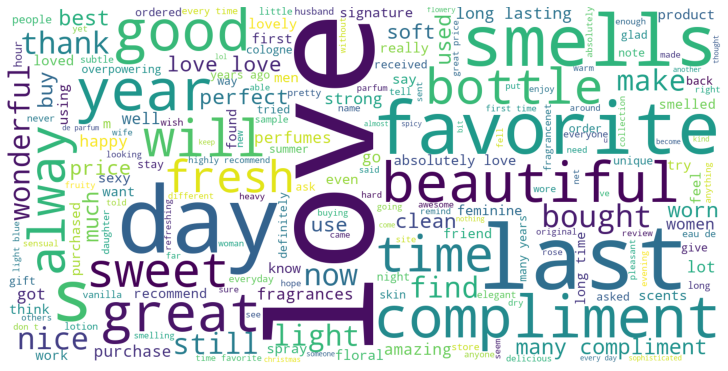

In [1080]:
text_high = " ".join(review for review in merged[merged['num_rating'] > 3].review_text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1400, height=700).generate(text_high)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [1081]:
merged.to_csv('merged_data.csv', index = False)